In [ ]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as pltA
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from PIL import Image
import os
from IPython.display import display
from IPython.display import Image as _Imgdis

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Untitled folder/PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [ ]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


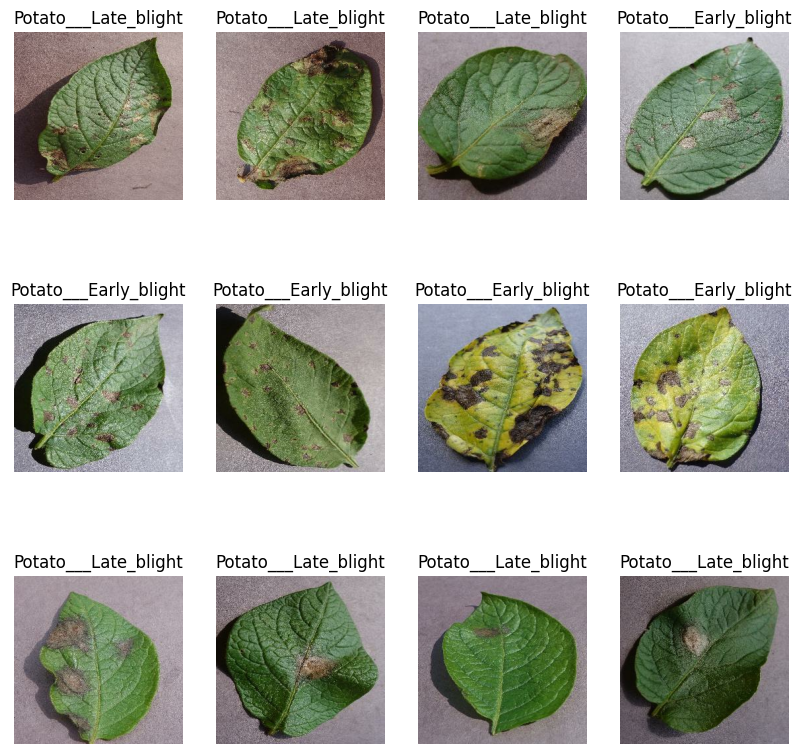

In [ ]:
plt.figure(figsize=(10,10))
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())
    for i in range(12):
        ax= plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
train_size= 0.8
len(dataset)*train_size

54.400000000000006

In [ ]:
train_ds = dataset.take(54)
len(train_ds)

54

In [ ]:
test_ds=dataset.skip(54)
len(test_ds)

14

In [ ]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [ ]:
val_ds=test_ds.take(6)
len(val_ds)

6

In [ ]:
test_ds=test_ds.skip(6)
len(test_ds)

8

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

54

In [ ]:
len(val_ds)

6

In [ ]:
len(test_ds)

8

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
vgg = VGG16(input_shape=[256,256] + [3], weights='imagenet', include_top=False)

58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
vgg.input

<KerasTensor: shape=(None, 256, 256, 3) dtype=float32 (created by layer 'input_1')>

In [ ]:
folders = glob('/content/drive/MyDrive/Untitled folder/PlantVillage/*')
print(len(folders))

3


In [ ]:
for layer in vgg.layers:
  layer.trainable = False

In [ ]:
x = Flatten()(vgg.output)
prediction = Dense(len(folders), activation='softmax')(x)
model = Model(inputs=vgg.input, outputs=prediction)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [ ]:
from keras import optimizers


adam = optimizers.Adam()
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer=adam,
              metrics=['accuracy'])

In [ ]:
from datetime import datetime
from keras.callbacks import ModelCheckpoint



checkpoint = ModelCheckpoint(filepath='mymodel.h5',
                               verbose=2, save_best_only=True)

callbacks = [checkpoint]

start = datetime.now()

model_history=model.fit_generator(
    train_ds,
    validation_data=val_ds,
    verbose=1,
    epochs=10,)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/10


<ipython-input-28-09b4fd196198>:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history=model.fit_generator(


54/54 [==============================] - 418s 261ms/step - loss: 4.0404 - accuracy: 0.8576 - val_loss: 0.3894 - val_accuracy: 0.9740
Epoch 2/10
54/54 [==============================] - 10s 186ms/step - loss: 0.2794 - accuracy: 0.9838 - val_loss: 0.0855 - val_accuracy: 0.9948
Epoch 3/10
54/54 [==============================] - 10s 192ms/step - loss: 0.1690 - accuracy: 0.9884 - val_loss: 0.0040 - val_accuracy: 0.9948
Epoch 4/10
54/54 [==============================] - 10s 186ms/step - loss: 0.1283 - accuracy: 0.9925 - val_loss: 0.0082 - val_accuracy: 0.9948
Epoch 5/10
54/54 [==============================] - 10s 194ms/step - loss: 0.0386 - accuracy: 0.9936 - val_loss: 0.0677 - val_accuracy: 0.9948
Epoch 6/10
54/54 [==============================] - 10s 188ms/step - loss: 0.1245 - accuracy: 0.9884 - val_loss: 4.7808e-08 - val_accuracy: 1.0000
Epoch 7/10
54/54 [==============================] - 10s 186ms/step - loss: 0.1186 - accuracy: 0.9925 - val_loss: 0.0300 - val_accuracy: 0.9948
Epoch

In [ ]:
scores= model.evaluate(test_ds)

8/8 [==============================] - 6s 169ms/step - loss: 2.3283e-09 - accuracy: 1.0000


In [ ]:
scores

[2.3283059924494864e-09, 1.0]

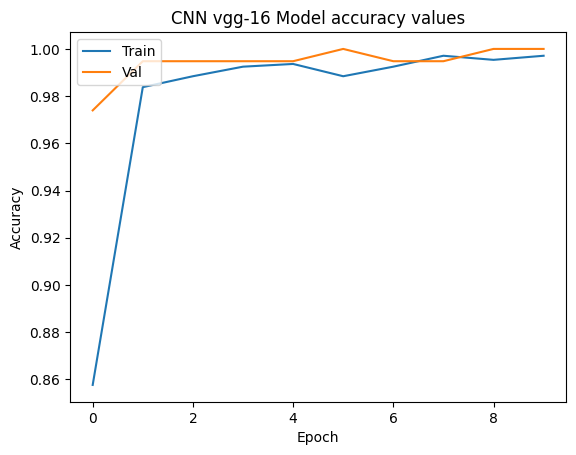

In [ ]:
# Plot training & validation loss values
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('CNN vgg-16 Model accuracy values')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

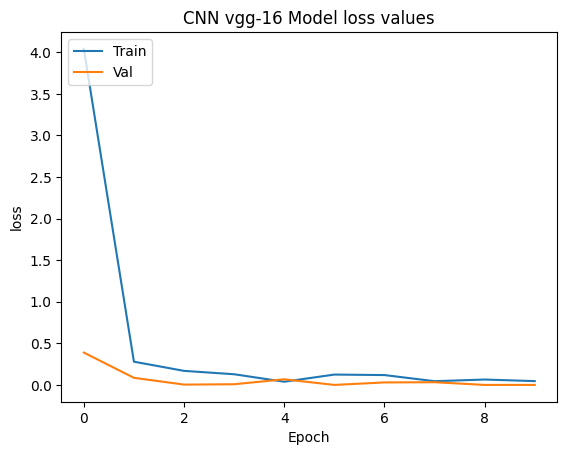

In [ ]:
# Plot training & validation loss values
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('CNN vgg-16 Model loss values')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

first image to predict
actual label: Potato___healthy
1/1 [==============================] - 0s 272ms/step
predicted label: Potato___healthy


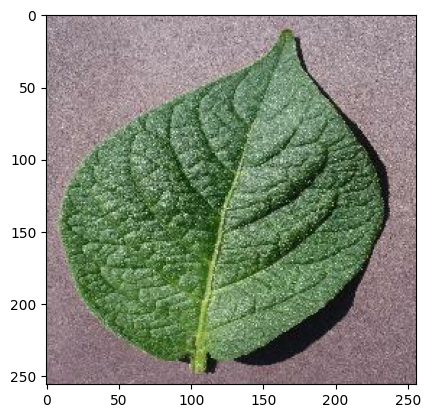

In [ ]:
import numpy as np
for images_batch, labels_batch in val_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 24ms/step


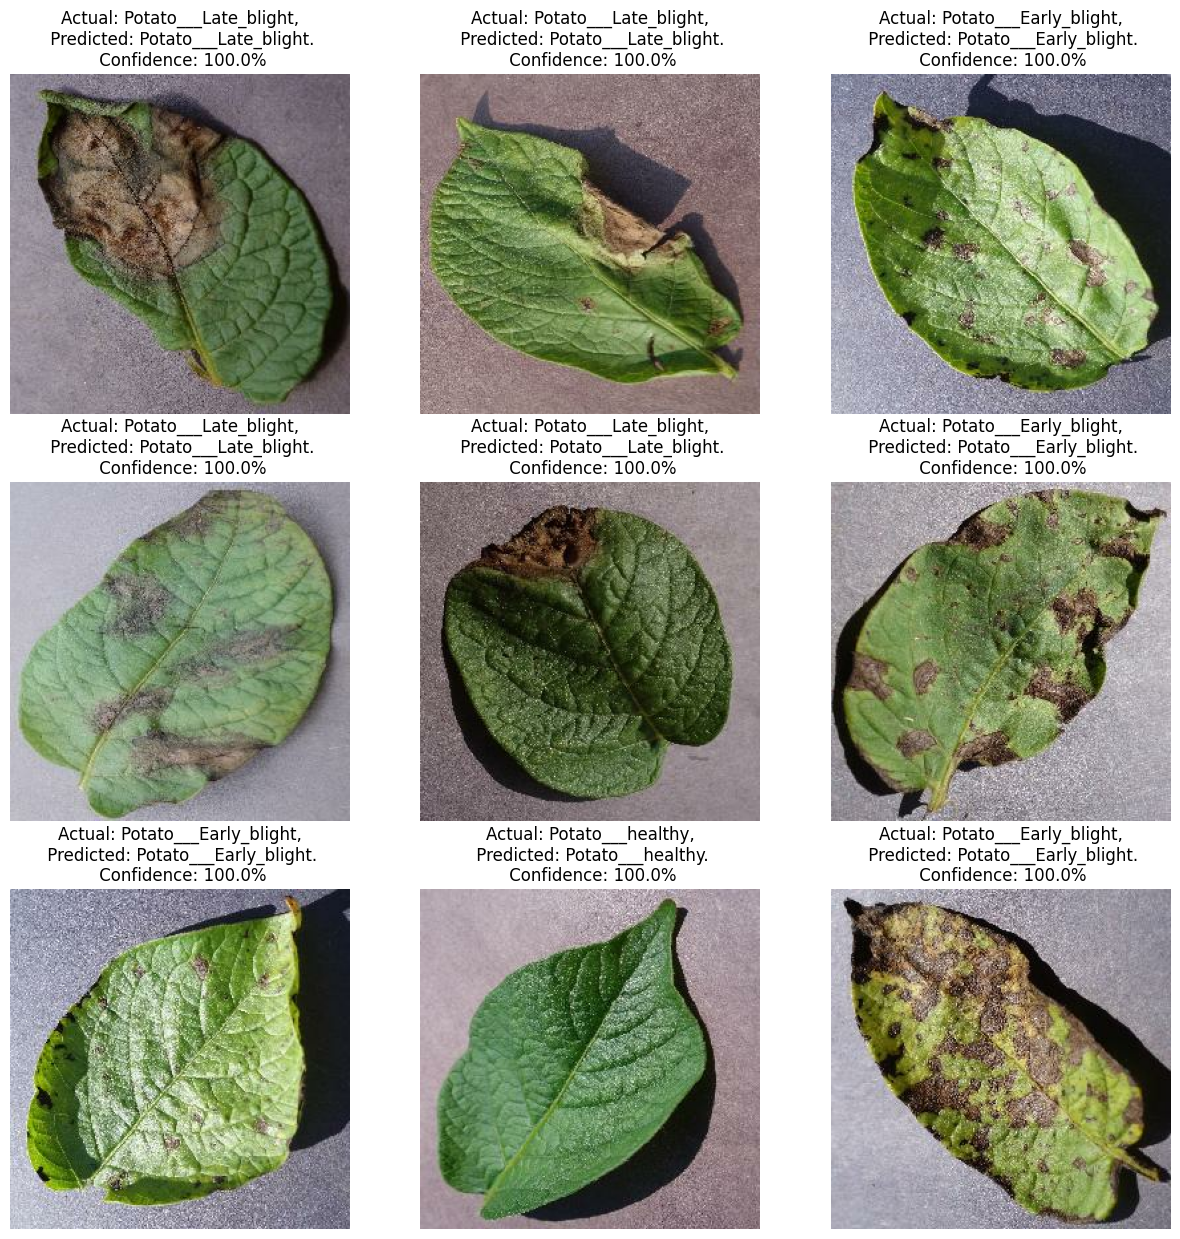

In [ ]:
plt.figure(figsize=(15, 15))
image_count = 0
for images, labels in val_ds.take(1):
    for i in range(9):
        if image_count >= len(images):
            break

        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[image_count].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[image_count].numpy())
        actual_class = class_names[labels[image_count]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

        image_count += 1


In [ ]:
import os

model_dir = "/content/drive/MyDrive/Untitled folder/model2"
os.makedirs(model_dir, exist_ok=True)

model_version = max([int(i) for i in os.listdir(model_dir) + [0]]) + 1
model.save(f"{model_dir}/{model_version}")